### Data load

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

titanic = pd.read_csv('../../data/titanic_train.csv')
titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [32]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [33]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [34]:
titanic.dtypes[titanic.dtypes == 'object']

Name        object
Sex         object
Ticket      object
Cabin       object
Embarked    object
dtype: object

In [35]:
from sklearn.preprocessing import LabelEncoder
# preprocessing 함수화하기

# Null 값 처리
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    # df['Fare'].fillna(0, inplace=True)
    return df

# 불필요한 feature 지우기
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def label_encoding(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        
    return df

# 위의 process 수행
def preprocessing(df):
    df = fillna(df)
    df = drop_features(df)
    df = label_encoding(df)
    return df

In [36]:
titanic['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [37]:
titanic_df = preprocessing(titanic)

In [42]:
# train_test_split
# accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

y = titanic_df['Survived']
X = titanic_df.drop('Survived', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)

print("accuracy : {0:.3f}".format(accuracy_score(y_test, pred)))

accuracy : 0.793


### 오차행렬, 정확도, 정밀도, 재현율 함수

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    print('오차 행렬')
    print(confusion)
    print("정확도 : {0:.3f}, 정밀도 : {1:.3f}, 재현율 : {2:.3f}".format(accuracy, precision, recall))

In [50]:
# 전체 과정 한번에 하기
titanic = pd.read_csv('../../data/titanic_train.csv')
titanic_pre = preprocessing(titanic)
y_label = titanic_pre['Survived']
X_feature = titanic_pre.drop('Survived', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_feature, y_label, test_size=0.2, random_state=156)

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)

get_clf_eval(y_test, pred)

오차 행렬
[[94 13]
 [20 52]]
정확도 : 0.816, 정밀도 : 0.800, 재현율 : 0.722


### 분류 결정 임계값 0.5기반에서 Binarizer를 이용하여 예측값 변환

In [51]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [53]:
from sklearn.preprocessing import Binarizer

pred_proba = lr_clf.predict_proba(X_test)

custom_threshold = 0.5
pred_proba_1 = pred_proba[:,1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[94 13]
 [20 52]]
정확도 : 0.816, 정밀도 : 0.800, 재현율 : 0.722


In [54]:
from sklearn.preprocessing import Binarizer

pred_proba = lr_clf.predict_proba(X_test)
# threshold를 높여보기 
custom_threshold = 0.7
pred_proba_1 = pred_proba[:,1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

# 정확도는 떨어졌지만, 정밀도는 올라감

오차 행렬
[[106   1]
 [ 35  37]]
정확도 : 0.799, 정밀도 : 0.974, 재현율 : 0.514


### precision_recall_curve()를 이용하여 임곗값에 따른 정밀도-재현율 값 추출

In [55]:
from sklearn.metrics import precision_recall_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precision, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 개열의 shape : ', pred_proba_class1.shape)
print('반환된 precisions 배열의 shape: ', precision.shape)
print('반환된 recalls 배열의 shape: ', recalls.shape)

print('thresholds 5 sample: ', thresholds[:5])
print('precision 5 sample: ', precision[:5])
print('recalls 5 sample: ', recalls[:5])


반환된 분류 결정 임계값 개열의 shape :  (179,)
반환된 precisions 배열의 shape:  (168,)
반환된 recalls 배열의 shape:  (168,)
thresholds 5 sample:  [0.01380866 0.04350918 0.04616887 0.05747518 0.06025684]
precision 5 sample:  [0.40223464 0.40677966 0.40909091 0.41142857 0.4137931 ]
recalls 5 sample:  [1. 1. 1. 1. 1.]


In [57]:
thr_index = np.arange(0, thresholds.shape[0], 15)
print(thr_index)
# threshold 값 변화
print(np.round(thresholds[thr_index], 2))

# threshold 값에 대한 정밀도와 재현율
print(np.round(precision[thr_index], 3))
print(np.round(recalls[thr_index], 3))

[  0  15  30  45  60  75  90 105 120 135 150 165]
[0.01 0.08 0.11 0.12 0.14 0.23 0.35 0.51 0.63 0.72 0.89 0.94]
[0.402 0.436 0.466 0.512 0.564 0.638 0.731 0.81  0.875 0.969 1.    1.   ]
[1.    0.986 0.958 0.889 0.861 0.833 0.792 0.708 0.583 0.431 0.236 0.028]


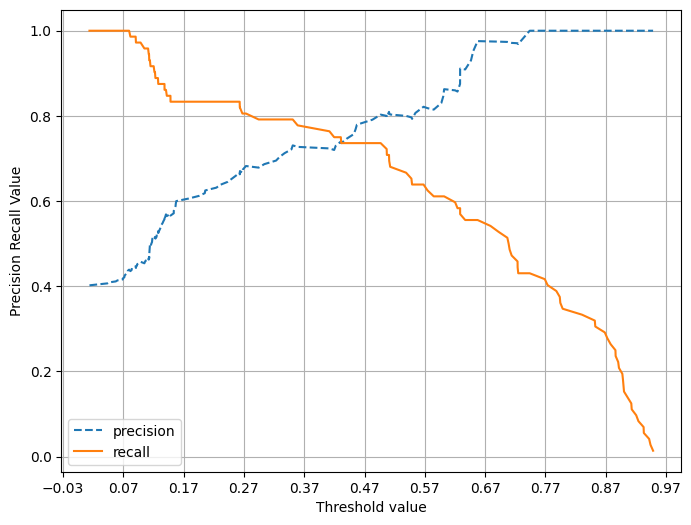

In [58]:
# 임곗값의 변경에 따른 정밀도-재현율 변화 곡선을 그림
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba):
    precision, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precision[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision Recall Value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, pred_proba_class1)

### F1 Score

In [59]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 Score: {0:.3f}'.format(f1))

F1 Score: 0.759


### ROC Curve와 AUC

In [62]:
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
print(thresholds)

[1.94864446 0.94864446 0.74399186 0.7249644  0.65757142 0.63699456
 0.62860355 0.62857597 0.62426587 0.60207405 0.58483304 0.56788639
 0.54890008 0.51061233 0.50707609 0.49675479 0.43134879 0.43072528
 0.4196761  0.35095944 0.29441338 0.27339899 0.26747466 0.26342225
 0.26320906 0.26291549 0.25636814 0.24309444 0.15661269 0.15362788
 0.14824985 0.14815042 0.14211542 0.14070841 0.13830973 0.13826122
 0.12789647 0.12742293 0.12319313 0.12248903 0.12162236 0.12031434
 0.11808449 0.11755917 0.11644251 0.11505107 0.11403227 0.11299825
 0.11294956 0.11276557 0.11265414 0.11214991 0.11104725 0.10491792
 0.09853566 0.09091807 0.09043389 0.08170313 0.07956289 0.04350918
 0.01380866]


In [63]:
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51 56]
샘플 index로 추출한 임곗값:  [0.95 0.63 0.57 0.43 0.27 0.26 0.15 0.13 0.12 0.11 0.11 0.09]
샘플 임곗값별 FPR:  [0.    0.037 0.093 0.178 0.252 0.29  0.43  0.533 0.579 0.636 0.738 0.822]
샘플 임곗값별 TPR:  [0.014 0.569 0.639 0.736 0.806 0.833 0.847 0.875 0.917 0.931 0.944 0.986]


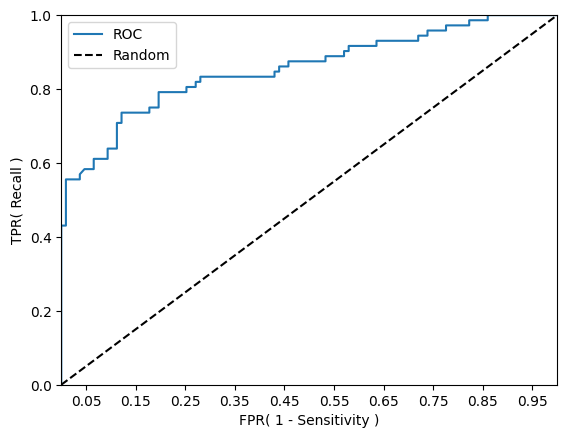

In [64]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )

In [65]:
from sklearn.metrics import roc_auc_score


pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

ROC AUC 값: 0.8553
